In [109]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

from nltk.stem import PorterStemmer
from wordcloud import STOPWORDS

from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')#to filter all the warnings
import seaborn as sns
pd.set_option('float_format', '{:.4f}'.format)# to keep the float values short

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv('../data/preprocessed/video_cln.csv')
df.head(1)

,video_id,trending_date,category_id,publish_time,views,likes,dislikes,comment_count,category_name,tags,video_title,channel_title,description
0,2kyS6SvSYSE,2017-11-14,22,2017-11-13 17:13:01,748374,57527,2966,15954,People & Blogs,shantell martin,we want to talk about our marriage,caseyneistat,shantell s channel https www youtube com shant...


#### Mantendremos solo la ultima aparcicion de un video_id

In [7]:
df.drop_duplicates(subset=['video_id'], keep='last', inplace = True)

#### Eliminamos las columnas que no nos ayudan a la clasificacion por categorias

In [8]:
df.drop(['video_id', 'trending_date', 'category_id', 'publish_time', 'views', 'likes', 'dislikes',\
        'comment_count', 'channel_title'], axis=1, inplace=True)

In [9]:
df.head(2)

,category_name,tags,video_title,description
10,Sports,nfl football offense defense afc nfc american ...,dion lewis 103-yd kick return td vs denver can...,new england patriots returner dion lewis blast...
36,Film & Animation,screenjunkies screen junkies sj news honest tr...,tl dw every dceu movie before justice league,with justice league approaching fast we rewatc...


#### Verificamos por entradas NaN

In [10]:
df.isna().sum()

category_name    0
tags             0
video_title      1
description      0
dtype: int64

Podemos usar un `string` vacio para lidiar con esta unica entrada `NaN`

In [11]:
df.fillna(' ', inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6351 entries, 10 to 40948
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_name  6351 non-null   object
 1   tags           6351 non-null   object
 2   video_title    6351 non-null   object
 3   description    6351 non-null   object
dtypes: object(4)
memory usage: 248.1+ KB


#### Para obtener mejores resultados, combinaremos todo el texto de un video `description`, `tags` y `video_title` 

In [13]:
df['text_combined'] = df['tags'] + ' ' + df['description'] + ' ' + df['video_title']

In [14]:
df.head(1)

,category_name,tags,video_title,description,text_combined
10,Sports,nfl football offense defense afc nfc american ...,dion lewis 103-yd kick return td vs denver can...,new england patriots returner dion lewis blast...,nfl football offense defense afc nfc american ...


#### Completado y verificado el paso anterior podemos borrar las columnas individuales usadas

In [15]:
df.drop(['tags', 'description', 'video_title'], axis=1, inplace=True)

In [17]:
pd.set_option("display.max_colwidth", -1)

In [18]:
df.head(1)

,category_name,text_combined
10,Sports,nfl football offense defense afc nfc american football highlight highlights game games sport sports action play plays season 2017 rookie rookies recap run sprint catch huge amazing touchdown td week 9 wk 9 new england patriots pats denver broncos lewis kickoff kick return return td special teams sp dt 2017-11-12t20 30 00-05 00 sp vl en-us sp st football sp li nfl sp ti home den sp ti away ne sp scp athlete_in_match sp ty high nfl-lewdio new england patriots returner dion lewis blasts off for an amazing kickoff return touchdown against the denver broncos in week 10 of the 2017 nfl season n nwatch full games with nfl game pass https www nfl com gamepass campaign sp-nf-gd-ot-yt-3000342 n nsign up for fantasy football http www nfl com fantasyfootball n nsubscribe to nfl http j mp 1l0bvbu n nthe nfl youtube channel is your home for immediate in-game highlights from your favorite teams and players full nfl games behind the scenes access and more n ncheck out our other channels nnfl network http www youtube com nflnetwork nnfl films http www youtube com nflfilms n nfor all things nfl visit the league s official website at http www nfl com n nwatch nfl now https www nfl com now nlisten to nfl podcasts http www nfl com podcasts nwatch the nfl network http nflnonline nfl com ndownload the nfl mobile app https www nfl com apps n2017 nfl schedule http www nfl com schedules nbuy tickets to watch your favorite team http www nfl com tickets nshop nfl http www nflshop com source bm-nflcom-header-shop-tab n nlike us on facebook https www facebook com nfl nfollow us on twitter https twitter com nfl nfollow us on instagram https instagram com nfl nfind us on snapchat dion lewis 103-yd kick return td vs denver can t-miss play nfl wk 10 highlights


#### Existen muchas palabras o digitos que no aportan informacion a nuestro modelo
Crearemos una funcion que transforme las palabras existente `Lematization` 

In [26]:
stopwords = set(STOPWORDS)
stopwords.update(['follow', 'twitter', 'social', 'instagram', 'subscribe', 'snapchat', 'youtube', 'videos', 'video'\
                  ,'channel', 'share', 'facebook', 'comment', 'like', 'take', 'go', 'got', 'back',\
                  'much', 'made', 'keep', 'watch','none', 'check', 'will', 'make', 'https',\
                  'nfollow', 'ntwitter', 'nsocial', 'ninstagram', 'nhttp', 'nfacebook',\
                  'n', 'nhttps', 'tumblr', 'e', 'youtube', 'netflix', 'bit', 'ly',\
                  'nwatch', 'goo', 'gl', 'amzn', 'nnbc', 'nbc', 'youtu', 'nlike',\
                  'google', 'plus', 'nclick', 'nbctv', 'c', 's', 'nsubscribe', 'iphone',\
                  'pl7u4lwxq3wfi_7pgx0c-vtiwleu0s4v34', '2018', 'nlearn'])

In [36]:
def preprocessing(text):
    stemmer = PorterStemmer()
    processed_text = ''
    for word in text.split():
        if not word.isalpha() or len(word) < 3:
            continue
        elif not word in stopwords:
            processed_text += stemmer.stem(word) + " "

    return processed_text

In [23]:
test = """
nfl football offense defense afc nfc american football highlight highlights game games 
sport sports action play plays season 2017 rookie rookies recap run sprint catch huge 
amazing touchdown td week 9 wk 9 new england patriots pats denver broncos lewis kickoff 
kick return return td special teams sp dt 2017-11-12t20 30 00-05 00 sp vl en-us sp st 
football sp li nfl sp ti home den sp ti away ne sp scp athlete_in_match sp ty high 
nfl-lewdio new england patriots returner dion lewis blasts off for an amazing kickoff 
return touchdown against the denver broncos in week 10 of the 2017 nfl season n nwatch 
full games with nfl game pass https www nfl com gamepass campaign sp-nf-gd-ot-yt-3000342 
n nsign up for fantasy football http www nfl com fantasyfootball n nsubscribe to nfl http 
j mp 1l0bvbu n nthe nfl youtube channel is your home for immediate in-game highlights 
from your favorite teams and players full nfl games behind the scenes access and more n 
ncheck out our other channels nnfl network http www youtube com nflnetwork nnfl films http 
www youtube com nflfilms n nfor all things nfl visit the league s official website at http 
www nfl com n nwatch nfl now https www nfl com now nlisten to nfl podcasts http www nfl com 
podcasts nwatch the nfl network http nflnonline nfl com ndownload the nfl mobile app https 
www nfl com apps n2017 nfl schedule http www nfl com schedules nbuy tickets to watch your 
favorite team http www nfl com tickets nshop nfl http www nflshop com source 
bm-nflcom-header-shop-tab n nlike us on facebook https www facebook com nfl nfollow us on 
twitter https twitter com nfl nfollow us on instagram https instagram com nfl nfind us on 
snapchat dion lewis 103-yd kick return td vs denver can t-miss play nfl wk 10 highlights
"""

In [37]:
preprocessing(test)

'nfl footbal offens defens afc nfc american footbal highlight highlight game game sport sport action play play season rooki rooki recap run sprint catch huge amaz touchdown week new england patriot pat denver bronco lewi kickoff kick return return special team footbal nfl home den away scp high new england patriot return dion lewi blast amaz kickoff return touchdown denver bronco week nfl season full game nfl game pass nfl gamepass campaign nsign fantasi footbal nfl fantasyfootbal nfl nthe nfl home immedi highlight favorit team player full nfl game behind scene access ncheck channel nnfl network nflnetwork nnfl film nflfilm nfor thing nfl visit leagu offici websit nfl nfl now nfl now nlisten nfl podcast nfl podcast nfl network nflnonlin nfl ndownload nfl mobil app nfl app nfl schedul nfl schedul nbuy ticket favorit team nfl ticket nshop nfl nflshop sourc nfl nfl nfl nfind dion lewi kick return denver play nfl highlight '

Aplicamos la funcion creada sobre nuestra columna `text_combined`

In [38]:
df['text_combined'] = df['text_combined'].apply(preprocessing)

Es momento de analizar el balance de nuestro datos por categoria

In [45]:
df['category_name'].value_counts().to_frame()

,category_name
Entertainment,1621
Music,801
Howto & Style,594
Comedy,544
News & Politics,504
People & Blogs,495
Sports,449
Science & Technology,381
Film & Animation,320
Education,251


Tomaremos las 8 primeras categorias

In [62]:
categories_selected = ['Entertainment', 'Music', 'Howto & Style', 'Comedy',\
            'News & Politics', 'People & Blogs', 'Sports', 'Science & Technology']

df2 = df.apply(lambda r: r if r['category_name'] in categories_selected else np.NaN, axis=1)

In [ ]:
df2.dropna(axis=0, inplace=True)
df2

## Separacion de datos de entrenamiento y prueba

In [64]:
X = df2['text_combined']
y = df2['category_name']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

***Bag of Words Model***: es un método que se utiliza en el procesado del lenguaje para representar documentos ignorando el orden de las palabras. En este modelo, cada documento parece una bolsa que contiene algunas palabras.

In [66]:
# Applying bag of words to features in training and testing data
bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

In [ ]:
pd.DataFrame(X_train_bow)

In [68]:
#cl = RandomForestClassifier(random_state = 0, n_estimators=1000)
cl = RandomForestClassifier(random_state = 0)
cl.fit(X_train_bow, y_train)

RandomForestClassifier(random_state=0)

In [105]:
cl.score(X_test_bow, y_test)

0.7977736549165121

In [69]:
y_pred = cl.predict(X_test_bow)

In [71]:
print(classification_report(y_test,y_pred))

                      precision    recall  f1-score   support

              Comedy       0.81      0.81      0.81       166
       Entertainment       0.73      0.87      0.79       469
       Howto & Style       0.83      0.80      0.81       185
               Music       0.87      0.90      0.89       227
     News & Politics       0.77      0.90      0.83       164
      People & Blogs       0.79      0.42      0.55       151
Science & Technology       0.91      0.57      0.70       129
              Sports       0.90      0.87      0.88       126

            accuracy                           0.80      1617
           macro avg       0.83      0.77      0.78      1617
        weighted avg       0.81      0.80      0.79      1617



### Verificando los resultados

In [78]:
df_results = pd.DataFrame()
df_results['y_true'] = y_test
df_results['y_predict'] = y_pred

In [111]:
display(df_results['y_true'].value_counts().to_frame())
display(df_results['y_predict'].value_counts().to_frame())

,y_true
Entertainment,469
Music,227
Howto & Style,185
Comedy,166
News & Politics,164
People & Blogs,151
Science & Technology,129
Sports,126


,y_predict
Entertainment,562
Music,235
News & Politics,192
Howto & Style,179
Comedy,167
Sports,121
Science & Technology,81
People & Blogs,80


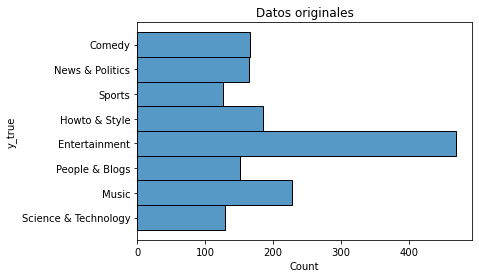

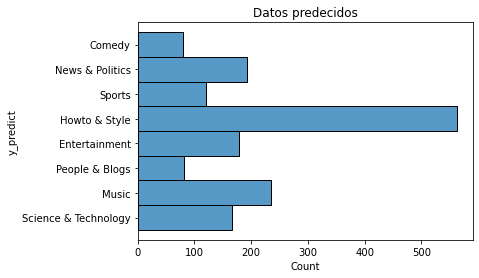

In [107]:
#fig, ax = plt.subplots(2,1, figsize=(8,12))
plt.figure()
sns.histplot(df_results, y='y_true')
plt.yticks(ticks=np.arange(len(df_results['y_true'].unique())), 
                 labels=df_results['y_true'].unique())
plt.title("Datos originales")

plt.figure()
sns.histplot(df_results, y='y_predict')
plt.yticks(np.arange(len(df_results['y_true'].unique())), df_results['y_true'].unique())
plt.title("Datos predecidos");


## Conclusiones

* El modelo de bolsa de palabras muestra una alta eficiencia para optimizar nuestro modelo clasificador, a pesar de la bajar cantidad de registros por categorias
* El estimador `RandomForestClassifier` demuestra una gran adaptacion a los datos, usando los parametros por defecto, implementando regularizacion, es posible mejorar el score obtenido de ***79%***